In [5]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("priyangshumukherjee/mental-health-text-classification-dataset")

print("Path to dataset files:", path)

100%|██████████| 17.1M/17.1M [00:01<00:00, 9.63MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/priyangshumukherjee/mental-health-text-classification-dataset/versions/2


In [1]:
!pip install -U transformers datasets accelerate evaluate scikit-learn matplotlib pandas==2.2.2



Step 1 — Imports + Set Dataset Path

In [2]:
import os, glob, re, numpy as np, pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

import torch
from datasets import Dataset
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    DataCollatorWithPadding, TrainingArguments, Trainer, set_seed
)

SEED = 42
set_seed(SEED)

DATA_DIR = "/root/.cache/kagglehub/datasets/priyangshumukherjee/mental-health-text-classification-dataset/versions/2"
print("Files:", os.listdir(DATA_DIR)[:20])


Files: ['mental_health_combined_test.csv', 'mental_heath_unbanlanced.csv', 'mental_heath_feature_engineered.csv']


Step 2 — Find and Load the CSV (Auto-detect)

In [3]:
csv_files = glob.glob(os.path.join(DATA_DIR, "*.csv"))
assert len(csv_files) > 0, "No CSV found in the dataset folder. Print os.listdir(DATA_DIR) and check file types."
csv_path = csv_files[0]
print("Using CSV:", csv_path)

df = pd.read_csv(csv_path)
print("Shape:", df.shape)
df.head()


Using CSV: /root/.cache/kagglehub/datasets/priyangshumukherjee/mental-health-text-classification-dataset/versions/2/mental_health_combined_test.csv
Shape: (992, 2)


,text,status
0,i don't understand whats wrong with me. i don'...,Anxiety
1,usually when i have anxiety just chatting with...,Anxiety
2,"well, i've had anxiety and panic syndrome for ...",Anxiety
3,"for the most minimal of things, like standing ...",Anxiety
4,i stay away from family and live with my roomm...,Anxiety


Step 3 — Standardize Column Names (Text + Label)

In [4]:
df_cols = [c.lower().strip() for c in df.columns]
col_map = {df.columns[i]: df_cols[i] for i in range(len(df.columns))}
df = df.rename(columns=col_map)

print("Columns:", df.columns.tolist())

# Candidate names
text_candidates = ["text", "sentence", "content", "tweet", "post", "statement", "body"]
label_candidates = ["label", "labels", "category", "class", "target", "emotion"]

text_col = next((c for c in text_candidates if c in df.columns), None)
label_col = next((c for c in label_candidates if c in df.columns), None)

# Fallback: pick the longest average string column as text, and a low-unique column as label
if text_col is None:
    obj_cols = [c for c in df.columns if df[c].dtype == "object"]
    assert len(obj_cols) > 0, "No text-like columns detected."
    text_col = max(obj_cols, key=lambda c: df[c].astype(str).str.len().mean())

if label_col is None:
    # label likely has fewer unique values than text
    candidates = [c for c in df.columns if c != text_col]
    label_col = min(candidates, key=lambda c: df[c].nunique())

print("Detected text_col:", text_col)
print("Detected label_col:", label_col)

df = df[[text_col, label_col]].rename(columns={text_col: "text", label_col: "label"})
df.head()



Columns: ['text', 'status']
Detected text_col: text
Detected label_col: status


,text,label
0,i don't understand whats wrong with me. i don'...,Anxiety
1,usually when i have anxiety just chatting with...,Anxiety
2,"well, i've had anxiety and panic syndrome for ...",Anxiety
3,"for the most minimal of things, like standing ...",Anxiety
4,i stay away from family and live with my roomm...,Anxiety


Step 4 — Basic Cleaning (Recommended for Social/Text Data)


In [5]:
def clean_text(s: str) -> str:
    s = str(s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

df["text"] = df["text"].apply(clean_text)

# Drop empty rows
df = df[df["text"].str.len() > 0].copy()
df = df.dropna(subset=["label"]).copy()

print("After cleaning:", df.shape)
df.head()


After cleaning: (992, 2)


,text,label
0,i don't understand whats wrong with me. i don'...,Anxiety
1,usually when i have anxiety just chatting with...,Anxiety
2,"well, i've had anxiety and panic syndrome for ...",Anxiety
3,"for the most minimal of things, like standing ...",Anxiety
4,i stay away from family and live with my roomm...,Anxiety


**PART A — EDA (Dataset Evaluation)**

Step 5 — Label Distribution + Missing Values

Missing values:
 text     0
label    0
dtype: int64 

Unique labels: 4
Label counts:
 label
Anxiety       248
Depression    248
Normal        248
Suicidal      248
Name: count, dtype: int64


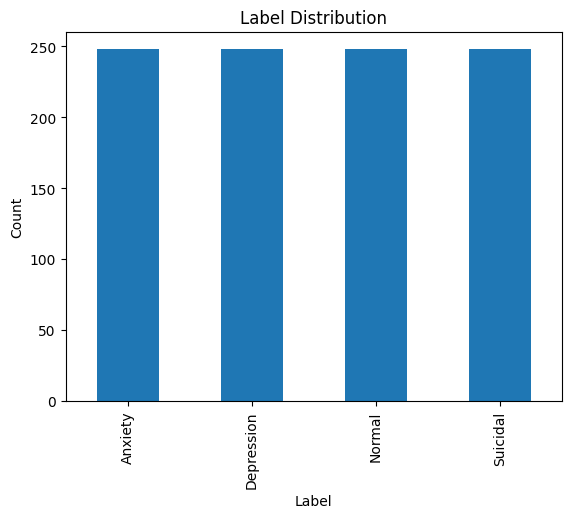

count     992.000000
mean      147.028226
std       241.877318
min         3.000000
25%        41.000000
50%        85.000000
75%       173.000000
max      5417.000000
Name: text_len, dtype: float64


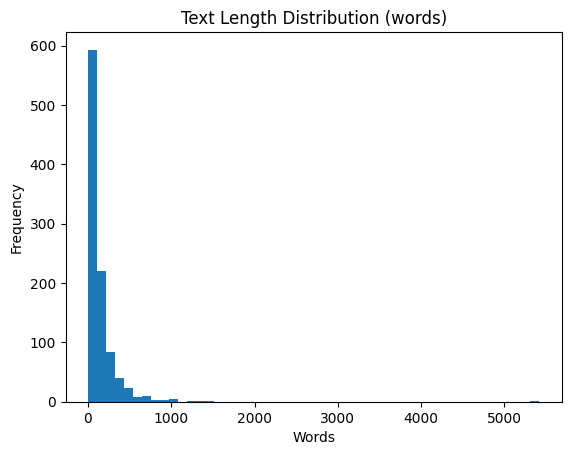

In [6]:
print("Missing values:\n", df.isna().sum(), "\n")
print("Unique labels:", df["label"].nunique())
print("Label counts:\n", df["label"].value_counts())

plt.figure()
df["label"].value_counts().plot(kind="bar")
plt.title("Label Distribution")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

# Text length stats
df["text_len"] = df["text"].str.split().apply(len)
print(df["text_len"].describe())

plt.figure()
plt.hist(df["text_len"], bins=50)
plt.title("Text Length Distribution (words)")
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.show()


Step 6 — Example Samples Per Class

In [7]:
for lab in df["label"].value_counts().index[:5]:
    print("\n====================")
    print("Label:", lab)
    print(df[df["label"] == lab]["text"].iloc[0][:400])



Label: Anxiety
i don't understand whats wrong with me. i don't know why i freak out sometimes. like right now i'm just laying in bed nothing is happening but i can't keep the tears running from down my face. it's stupid. i'm honestly fine nothing is wrong. why on earth am i like this?

Label: Depression
i'm talking about the kind of people who'd say "talk to someone" but would happily ignore you when trying to talk about it to them. this leads to feeling annoyed at yourself for bothering them and then bottling everything up and not talking to anyone about it.

Label: Normal
Used to keep it cool Used to be a fool All about the bounce in my step Watch it on the news Watchya gonna do I could hit refresh and forget Used to keep it cool *epic trumpet noises*

Label: Suicidal
Todays the day..I've got the thing I'll h*ng myself with. I'm just procrastinating.... I'm scared, and I just feel guilty. I couldnt sleep last night I kept thinking about who will find me just hanging there... it sadd

**PART B — 5-Epoch Pretrained Model Training + Metrics**

Step 7 — Encode Labels


In [8]:
# Ensure label is categorical => integer IDs
if df["label"].dtype == "object":
    label_list = sorted(df["label"].unique().tolist())
    label2id = {l:i for i,l in enumerate(label_list)}
    id2label = {i:l for l,i in label2id.items()}
    df["label_id"] = df["label"].map(label2id).astype(int)
else:
    # numeric labels
    df["label_id"] = df["label"].astype(int)
    label_list = sorted(df["label_id"].unique().tolist())
    id2label = {i:str(i) for i in label_list}
    label2id = {str(i):i for i in label_list}

num_labels = df["label_id"].nunique()
print("num_labels:", num_labels)
print("id2label sample:", dict(list(id2label.items())[:10]))


num_labels: 4
id2label sample: {0: 'Anxiety', 1: 'Depression', 2: 'Normal', 3: 'Suicidal'}


Step 8 — Train/Val/Test Split (Stratified)

In [9]:
train_df, temp_df = train_test_split(
    df[["text", "label_id"]],
    test_size=0.20,
    random_state=SEED,
    stratify=df["label_id"]
)

val_df, test_df = train_test_split(
    temp_df,
    test_size=0.50,
    random_state=SEED,
    stratify=temp_df["label_id"]
)

print("Train:", train_df.shape, "Val:", val_df.shape, "Test:", test_df.shape)


Train: (793, 2) Val: (99, 2) Test: (100, 2)


Step-9 — Tokenizer + HF Datasets + Tokenization

In [10]:
import numpy as np
from datasets import Dataset
from transformers import AutoTokenizer, DataCollatorWithPadding

MODEL_NAME = "facebook/bart-base"   # ✅ BART pretrained

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# train_df, val_df, test_df must exist from Step-8
train_ds = Dataset.from_pandas(train_df.reset_index(drop=True))
val_ds   = Dataset.from_pandas(val_df.reset_index(drop=True))
test_ds  = Dataset.from_pandas(test_df.reset_index(drop=True))

def tokenize(batch):
    return tokenizer(
        batch["text"],
        truncation=True,
        max_length=256
    )

train_ds = train_ds.map(tokenize, batched=True)
val_ds   = val_ds.map(tokenize, batched=True)
test_ds  = test_ds.map(tokenize, batched=True)

# Rename label column to "labels" for Trainer
train_ds = train_ds.rename_column("label_id", "labels")
val_ds   = val_ds.rename_column("label_id", "labels")
test_ds  = test_ds.rename_column("label_id", "labels")

train_ds.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
val_ds.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
test_ds.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

print("STEP-9 OK ✅ BART tokenization done")



/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Map:   0%|          | 0/793 [00:00<?, ? examples/s]

Map:   0%|          | 0/99 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

STEP-9 OK ✅ BART tokenization done


Step-10 — Metrics (Accuracy, F1, Precision, Recall)

In [15]:
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

def compute_metrics(eval_pred):
    preds = eval_pred.predictions
    labels = eval_pred.label_ids

    # Handle tuple outputs (BART / newer HF versions)
    if isinstance(preds, (tuple, list)):
        preds = preds[0]

    preds = np.asarray(preds)

    # Convert logits → class ids
    if preds.ndim > 1:
        preds = np.argmax(preds, axis=-1)

    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average="weighted", zero_division=0),
        "precision": precision_score(labels, preds, average="weighted", zero_division=0),
        "recall": recall_score(labels, preds, average="weighted", zero_division=0),
    }

print("STEP-10 UPDATED ✅ compute_metrics fixed")


STEP-10 UPDATED ✅ compute_metrics fixed


Step-11 — Model + TrainingArguments (5 epochs) + Trainer

In [20]:
import torch
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer, set_seed

SEED = 42
set_seed(SEED)

# BART model for classification
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=num_labels
)

training_args = TrainingArguments(
    output_dir="mh_text_bart_model",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="steps",
    logging_steps=50,
    learning_rate=2e-5,
    per_device_train_batch_size=8,      # BART uses more memory than DistilBERT
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    weight_decay=0.01,
    warmup_ratio=0.1,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    save_total_limit=2,
    fp16=torch.cuda.is_available(),
    report_to="none",
    seed=SEED
)

from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics   # ← updated function
)

print("STEP-11 UPDATED ✅ trainer recreated")



Some weights of BartForSequenceClassification were not initialized from the model checkpoint at facebook/bart-base and are newly initialized: ['classification_head.dense.bias', 'classification_head.dense.weight', 'classification_head.out_proj.bias', 'classification_head.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1084958314.py:36: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


STEP-11 UPDATED ✅ trainer recreated


Step-12 — Train (10 epochs)

In [21]:
train_result = trainer.train()



Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.939100,0.767307,0.616162,0.573874,0.650538,0.616162
2,0.482800,0.354434,0.868687,0.870247,0.882595,0.868687
3,0.285500,0.370505,0.868687,0.869613,0.876383,0.868687
4,0.183300,0.357138,0.878788,0.880371,0.885412,0.878788
5,0.132900,0.464050,0.888889,0.890064,0.893065,0.888889
6,0.068100,0.490764,0.898990,0.898506,0.898755,0.898990
7,0.071500,0.522778,0.919192,0.920602,0.923077,0.919192
8,0.024800,0.565984,0.909091,0.910121,0.914696,0.909091
9,0.010100,0.544383,0.919192,0.920151,0.922185,0.919192
10,0.004800,0.557707,0.919192,0.920151,0.922185,0.919192


/usr/local/lib/python3.12/dist-packages/transformers/configuration_utils.py:461: UserWarning: Some non-default generation parameters are set in the model config. These should go into either a) `model.generation_config` (as opposed to `model.config`); OR b) a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model).This warning will become an exception in the future.
Non-default generation parameters: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/transformers/configuration_utils.py:461: UserWarning: Some non-default generation parameters are set in the model config. These should go into either a) `model.generation_config` (as opposed to `model.config`); OR b) a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model).This warning 

Step C — Evaluate (accuracy, f1, precision, loss)

In [22]:
print("Best checkpoint:", trainer.state.best_model_checkpoint)

val_metrics = trainer.evaluate(val_ds)
test_metrics = trainer.evaluate(test_ds)

print("\n===== VALIDATION METRICS =====")
print(val_metrics)

print("\n===== TEST METRICS =====")
print(test_metrics)

print("\nKey values you asked:")
print(f"Val  -> accuracy={val_metrics['eval_accuracy']:.4f}, f1={val_metrics['eval_f1']:.4f}, precision={val_metrics['eval_precision']:.4f}, loss={val_metrics['eval_loss']:.4f}")
print(f"Test -> accuracy={test_metrics['eval_accuracy']:.4f}, f1={test_metrics['eval_f1']:.4f}, precision={test_metrics['eval_precision']:.4f}, loss={test_metrics['eval_loss']:.4f}")


Best checkpoint: mh_text_bart_model/checkpoint-700



===== VALIDATION METRICS =====
{'eval_loss': 0.5227775573730469, 'eval_accuracy': 0.9191919191919192, 'eval_f1': 0.9206019377447949, 'eval_precision': 0.9230769230769231, 'eval_recall': 0.9191919191919192, 'eval_runtime': 0.5221, 'eval_samples_per_second': 189.628, 'eval_steps_per_second': 13.408, 'epoch': 10.0}

===== TEST METRICS =====
{'eval_loss': 0.7100573182106018, 'eval_accuracy': 0.87, 'eval_f1': 0.871645880574452, 'eval_precision': 0.8767022738630685, 'eval_recall': 0.87, 'eval_runtime': 0.4665, 'eval_samples_per_second': 214.34, 'eval_steps_per_second': 15.004, 'epoch': 10.0}

Key values you asked:
Val  -> accuracy=0.9192, f1=0.9206, precision=0.9231, loss=0.5228
Test -> accuracy=0.8700, f1=0.8716, precision=0.8767, loss=0.7101
